# Data Science Research Project
## Pridicting Customer Churn in Telecom Industry 

<b>1- General Information about the dataset</b>
* the dataset was taken from IBM business analytics community

<b>2- Project Opjectives:
* to utilize light gradient boosted machine (LGBM) in predicting customer churn and understand features importance.
* modeling umbalanced classes.
* to tune LGBM parameters using GridSearchCV to find the best performing parametes that suits the dataset.
* benchmarking the results to other research papers that used the same dataset for churn prediction.</b>

### Required Libraries

In [1]:
# Dataframe and plotting libraries
import numpy as np # For linear algebra
import pandas as pd # For data frame manipulation
import seaborn as sns # For visualization I
import matplotlib.pyplot as plt # For visualization II


# Machine Learing libraries
from sklearn.linear_model import LogisticRegression # Model 1
from sklearn.ensemble import RandomForestClassifier # Model 2
from sklearn.svm import SVC                         # Model 3
import xgboost as xgb                               # Model 4
from lightgbm import LGBMClassifier                 # Model 5

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit # To stratify split
from sklearn.model_selection import StratifiedKFold # To stratify kfolds
from sklearn.model_selection import GridSearchCV # To find best parameters 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support # To evaluate models
from sklearn.metrics import classification_report # To evaluate models
from sklearn.metrics import confusion_matrix # To plot models outcome


from sklearn.preprocessing import MinMaxScaler # To scale data
from imblearn.under_sampling import RandomUnderSampler # To undersample data
from imblearn.over_sampling import RandomOverSampler, SMOTE # To oversample and resample data



# Utility library
import pickle # Save the ML object model.
import os # To access directory
import warnings  # To mute warnings
warnings.filterwarnings("ignore") # Mute warning

%matplotlib inline 

C:\Users\HP\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\HP\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\HP\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\HP\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from panda

## Useful function for evaluation

In [48]:
# Defining auxiliary function 1
rs = 123 # Setting random state to '123' in all models and sampling.

# Defining auxiliary function 2
# evaluation metrics stored in a dictionary
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    W_precision, W_recall, W_fbeta, _ = precision_recall_fscore_support(yt, yp, average = 'weighted')
    
    results_pos['precision'] = precision
    results_pos['Weighted precision'] = W_precision
    results_pos['recall'] = recall
    results_pos['Weighted recall'] = W_recall
    results_pos['f1score'] = f_beta
    results_pos['Weighted f1score'] = W_fbeta
    return results_pos

# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()
    

## Importing the dataset

In [3]:
df = pd.read_csv('Telco-Customer-Churn.csv')# Reading the df

## Preprossing and General Understanding of the Data

In [4]:
print('The dataset first three rows are')
display(df.head(3))
print('')
print('The dataset last three rows are')
display(df.tail(3))

The dataset first three rows are


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes



The dataset last three rows are


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [5]:
print(f'The data frame encompasses {df.shape[0]} instances and {df.shape[1]} features\n')
print('The features data types are as follows,')
print(df.dtypes.value_counts())

The data frame encompasses 7043 instances and 21 features

The features data types are as follows,
object     18
int64       2
float64     1
dtype: int64


the column 'TotalCharges' contains numeric values but it's considered an object, that's why we need to change its type

In [6]:
# As there are few empty spaces in this column, we will replace those spaces with 0s
df_list = []
for i in df['TotalCharges']:
    try:
        df_list.append(float(i))
    except:
        df_list.append(float(0))
        
df['TotalCharges'] = df_list

In [7]:
print('Checking for missing values per column:')
print(df.isna().sum())

Checking for missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


As we're using decision trees algorithm as the base model of LGBM ensamble algorithm, we don't need to do feature scaling or encode the non numeric columns. However, because we're going to benchmark thr results with other machine learning algoirthm that might require encoding and feature scaling such as logistic regression, we will do those steps right now so we wont have to do them later.

### Encoding the Data:
For columns that has only two values, they will be converted to 1s and 0s, but for columns that have 3 values and more they will be one hot encoded.

In [8]:
# dropping 'customerID' column first.
df.drop('customerID', inplace=True, axis=1)
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
gender,2
SeniorCitizen,2
Partner,2
Dependents,2
tenure,73
PhoneService,2
MultipleLines,3
InternetService,3
OnlineSecurity,3


In [9]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [10]:
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [11]:
[[i, list(df[i].unique())] for i in categorical_variables]

[['MultipleLines', ['No phone service', 'No', 'Yes']],
 ['InternetService', ['DSL', 'Fiber optic', 'No']],
 ['OnlineSecurity', ['No', 'Yes', 'No internet service']],
 ['OnlineBackup', ['Yes', 'No', 'No internet service']],
 ['DeviceProtection', ['No', 'Yes', 'No internet service']],
 ['TechSupport', ['No', 'Yes', 'No internet service']],
 ['StreamingTV', ['No', 'Yes', 'No internet service']],
 ['StreamingMovies', ['No', 'Yes', 'No internet service']],
 ['Contract', ['Month-to-month', 'One year', 'Two year']],
 ['PaymentMethod',
  ['Electronic check',
   'Mailed check',
   'Bank transfer (automatic)',
   'Credit card (automatic)']]]

As we can see above there is only one ordinal variable in the categorical variables which is 'Contract. However, we will divide the 'tenure' column into separate bins and considere it an oridinal variable.

In [12]:
# ordinal_variables = ['tenure', 'Contract']
ordinal_variables = ['Contract', 'tenure']
df['tenure'] = pd.cut(df['tenure'], bins=7) #Binning, 7 bins because the range of values is 0 to 70 approximately.

# the only numeric variable that we have is 'TotalCharges', thus:
numeric_variables = ['TotalCharges', 'MonthlyCharges']

now let's scale all kinds of variables we have

In [13]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder

lb, le, od = LabelBinarizer(), LabelEncoder(), OrdinalEncoder() # Initialize encoding objects.
# We can use LabelEncoder for ordinal data if they are alphabetically ordered. (The contract in our case)

print(categorical_variables)
print(ordinal_variables)
print(numeric_variables)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
['Contract', 'tenure']
['TotalCharges', 'MonthlyCharges']


Tranforming ordinal data first

In [14]:
for column in ordinal_variables:
    df[column] = od.fit_transform(df[column].values.reshape(-1, 1))

Checking out the result

In [15]:
for column in ordinal_variables:
    print(column)
    print(df[column].sort_values().unique())

Contract
[0. 1. 2.]
tenure
[0. 1. 2. 3. 4. 5. 6.]


Transforming the biary vairables:

In [16]:
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])
for column in binary_variables:
    print(column)
    print(df[column].sort_values().unique())

gender
[0 1]
SeniorCitizen
[0 1]
Partner
[0 1]
Dependents
[0 1]
PhoneService
[0 1]
PaperlessBilling
[0 1]
Churn
[0 1]


Creating nominal variables and transforming them:

In [17]:
nominal_variables = list(set(categorical_variables) - set(ordinal_variables))
df = pd.get_dummies(df, columns = nominal_variables, drop_first=True)

In [18]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'Contract', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No'],
      dtype='object')

Congrats!, we have finished preprocessing the data, now we need to deal with the imbalanced target class

### Modeling the imbalanced Target Feature

In [19]:
print('The target feature is "Churn" where No means the customer did not churned and Ues means the customer churn.')
print('')
print('the ratios of classes are as follows')
print(df['Churn'].value_counts(normalize = True))

The target feature is "Churn" where No means the customer did not churned and Ues means the customer churn.

the ratios of classes are as follows
0    0.73463
1    0.26537
Name: Churn, dtype: float64


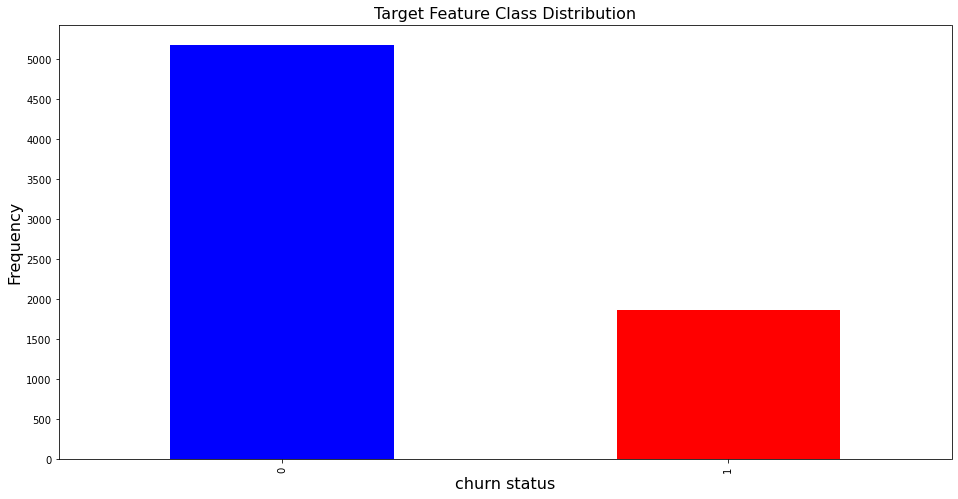

In [20]:
# Plotting the ratio between classes
from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(16, 8))
df['Churn'].value_counts().plot.bar(color= ['blue','red'])
ax.set_ylabel('Frequency',fontsize=16)
ax.set_xlabel('churn status',fontsize=16)
ax.set_title('Target Feature Class Distribution',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

#### As we can observe from the above graph, the target attribute is skewed to those who did not churn by a ratio of 1:2.5, which will make the model weak in predicting customers who churned, the problem here is that our focus is the customers that are churning because they're the problem that needs to be solved, therefor we need to model the imbalanced data using techniques such as downsampling, reqeighting and resampling to see which one performs better with LGBM model. 

#### we will split the data first before applying the techniques for modeling imbalanced data

In [21]:
# Identifying the feature columns
feature_cols = df.drop('Churn',axis = 1).columns.tolist()
feature_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'Contract',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'InternetService_Fiber optic',
 'InternetService_No']

In [22]:
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.25, # 25% to test the model peforamnce
                                          random_state=rs)

# We use 'next' to get the arrays from the generator object.
train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df['Churn']))

In [23]:
# Create the train and test sets
X_train = df.loc[train_idx, feature_cols] # loc[index,column]
y_train = df.loc[train_idx, 'Churn']

X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, 'Churn']

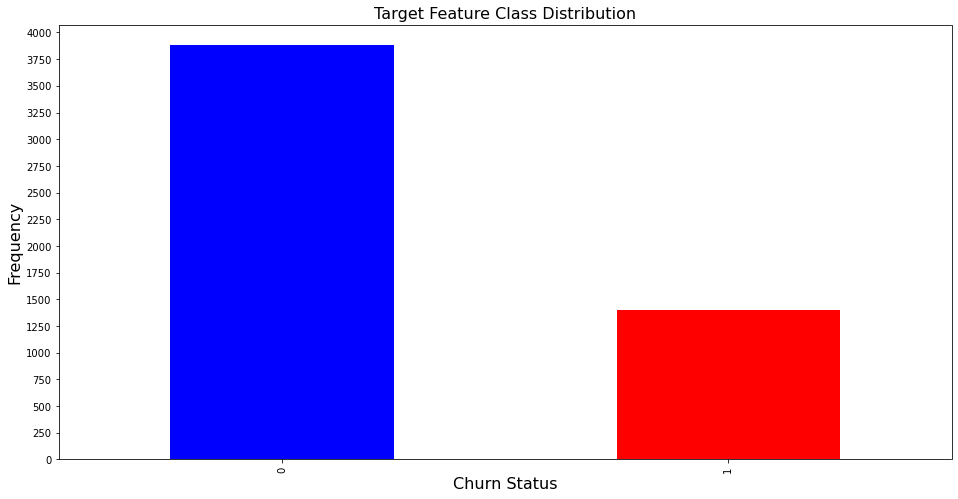

In [24]:
# Plotting y_train distribution
fig, ax = plt.subplots(figsize=(16, 8))
y_train.value_counts().plot.bar(color= ['blue','red'])
ax.set_xlabel('Churn Status',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_title('Target Feature Class Distribution',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

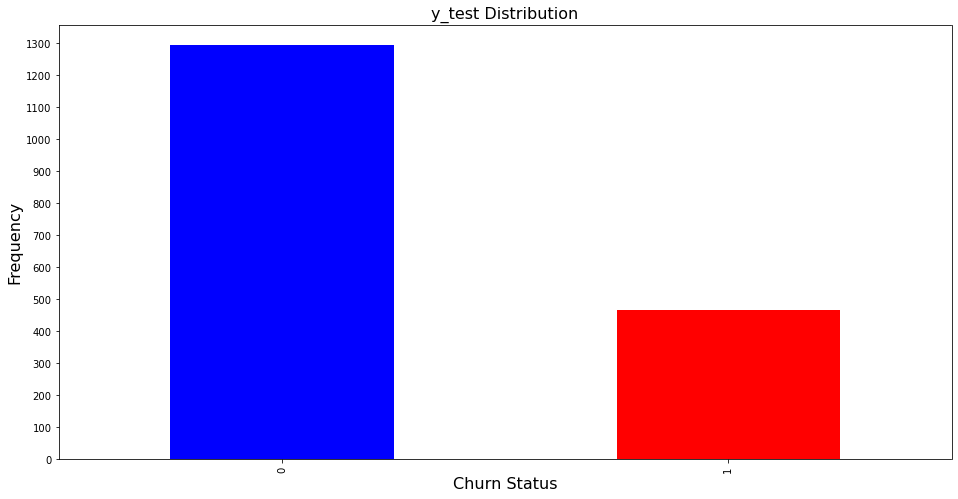

In [25]:
# Plotting y_test distribution
fig, ax = plt.subplots(figsize=(16, 8))
y_test.value_counts().plot.bar(color= ['blue','red'])
ax.set_xlabel('Churn Status',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_title('y_test Distribution',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

#### We will use Logistic Regression to see which modeling technique performs better.

### a. Reweighting Teachnique


In [26]:
# Initially, let's scale the numeric and ordinal attributes using min-max scaler. 
# There are two numeric columns that needs to be scaled: 'TotalCharges' and 'tenure'.
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
remaining_variables = ordinal_variables + numeric_variables
# creating a copy of the dataset to scale it
X_train_s = X_train
X_test_s = X_test
X_train_s[remaining_variables] = mm.fit_transform(X_train[remaining_variables])
X_test_s[remaining_variables] = mm.transform(X_test[remaining_variables])




In [27]:
print('number of values in each class')
print(y_train.value_counts())
print('Proportion of each class')
print(y_train.value_counts()/len(y_train.index))

number of values in each class
0    3880
1    1402
Name: Churn, dtype: int64
Proportion of each class
0    0.73457
1    0.26543
Name: Churn, dtype: float64


In [28]:
class_weight = {}
# we will distribute the weight of each class according to it's proportion of the total number of values.
class_weight[0] = 0.26543
class_weight[1] = 0.73457
# notice the the proportion of the bigger class was given as the weight for the smaller class and vice versa

In [29]:
# Define a logistic regression with weight
model = LogisticRegression(solver='saga', random_state=rs, class_weight=class_weight)
model.fit(X_train_s, y_train)
preds =  model.predict(X_test_s)

In [30]:
# Results

reweighted = evaluate_metrics(y_test,preds)
reweighted

{'accuracy': 0.750709823963657,
 'precision': array([0.90368272, 0.51994302]),
 'Weighted precision': 0.8019186992656869,
 'recall': array([0.73956723, 0.78158458]),
 'Weighted recall': 0.750709823963657,
 'f1score': array([0.81342966, 0.62446536]),
 'Weighted f1score': 0.7633181750921969}

In [31]:
# Storing evaluation metrics (average values)keys = ['accuracy','Weighted precision','Weighted recall','Weighted f1score']
reweighted_results = list()
keys = ['accuracy','Weighted precision','Weighted recall','Weighted f1score']
for key in keys:
       reweighted_results.append(reweighted.get(key))
reweighted_results    

[0.750709823963657, 0.8019186992656869, 0.750709823963657, 0.7633181750921969]

In [32]:
# storing evaluation metrics (per class)
reweighted_rpf = []
elements = ['precision','recall','f1score']
for element in elements:
       reweighted_rpf.append(reweighted.get(element))
reweighted_rpf     

[array([0.90368272, 0.51994302]),
 array([0.73956723, 0.78158458]),
 array([0.81342966, 0.62446536])]

### b. Undersampling Technique

In [35]:
under_sampler = RandomUnderSampler(random_state=rs) #initiating undersampling object
X_under, y_under = under_sampler.fit_resample(X_train_s, y_train)

In [36]:
print('y_train after undersampling')
y_under.value_counts() 

y_train after undersampling


0    1402
1    1402
Name: Churn, dtype: int64

In [37]:
model = LogisticRegression(solver='saga', random_state=rs)
model.fit(X_under, y_under)
preds = model.predict(X_test_s)

In [38]:
undersampling = evaluate_metrics(y_test,preds)
undersampling

{'accuracy': 0.7501419647927314,
 'precision': array([0.89757914, 0.51965066]),
 'Weighted precision': 0.7973561995688929,
 'recall': array([0.74497682, 0.76445396]),
 'Weighted recall': 0.7501419647927314,
 'f1score': array([0.81418919, 0.6187175 ]),
 'Weighted f1score': 0.7623520075719521}

In [39]:
# Storing evaluation metrics (average values)
undersampling_results = list()
for key in keys:
       undersampling_results.append(undersampling.get(key))
undersampling_results

[0.7501419647927314,
 0.7973561995688929,
 0.7501419647927314,
 0.7623520075719521]

In [40]:
# storing evaluation metrics (per class)
undersampling_rpf = []
for element in elements:
       undersampling_rpf.append(undersampling.get(element))
undersampling_rpf    

[array([0.89757914, 0.51965066]),
 array([0.74497682, 0.76445396]),
 array([0.81418919, 0.6187175 ])]

### c. Resampling Technique

In [41]:
smote_sampler = SMOTE(random_state = rs) #Initiating SMOTE sampler
X_smo, y_smo = smote_sampler.fit_resample(X_train_s, y_train)

In [42]:
y_smo.value_counts()

0    3880
1    3880
Name: Churn, dtype: int64

In [43]:
model = LogisticRegression(solver='saga', random_state=rs)

In [44]:
model.fit(X_smo, y_smo)
preds = model.predict(X_test_s)

In [45]:
resampling = evaluate_metrics(y_test, preds)
resampling

{'accuracy': 0.7501419647927314,
 'precision': array([0.88677536, 0.52054795]),
 'Weighted precision': 0.7896554283086534,
 'recall': array([0.75656878, 0.73233405]),
 'Weighted recall': 0.7501419647927314,
 'f1score': array([0.81651376, 0.60854093]),
 'Weighted f1score': 0.7613613966150448}

In [46]:
# Storing evaluation metrics (average values)
resampling_results = list()
for key in keys:
       resampling_results.append(resampling.get(key))
resampling_results

[0.7501419647927314,
 0.7896554283086534,
 0.7501419647927314,
 0.7613613966150448]

In [47]:
# storing evaluation metrics (per class)
resampling_rpf = []
for element in elements:
       resampling_rpf.append(resampling.get(element))
resampling_rpf   

[array([0.88677536, 0.52054795]),
 array([0.75656878, 0.73233405]),
 array([0.81651376, 0.60854093])]

### d. None modeled data

In [48]:
model = LogisticRegression(solver='saga', random_state=rs)
model.fit(X_train_s, y_train)
preds = model.predict(X_test_s)
no_model = evaluate_metrics(y_test, preds)
no_model

{'accuracy': 0.7927314026121521,
 'precision': array([0.83249821, 0.64010989]),
 'Weighted precision': 0.7814787069874328,
 'recall': array([0.89876352, 0.49892934]),
 'Weighted recall': 0.7927314026121521,
 'f1score': array([0.86436269, 0.56077016]),
 'Weighted f1score': 0.7838529156720054}

In [49]:
# Storing evaluation metrics (average values)
no_model_results = list()
for key in keys:
       no_model_results.append(no_model.get(key))
no_model_results

[0.7927314026121521,
 0.7814787069874328,
 0.7927314026121521,
 0.7838529156720054]

In [50]:
# storing evaluation metrics (per class)
no_model_rpf = []
for element in elements:
       no_model_rpf.append(no_model.get(element))
no_model_rpf   

[array([0.83249821, 0.64010989]),
 array([0.89876352, 0.49892934]),
 array([0.86436269, 0.56077016])]

In [51]:
final_results= {
    'Metric': ['Accuracy',' Weighted Recall','Weighted Precision','Weighted F1score'],
    'Reweighted' :reweighted_results,
    'Undersampled':undersampling_results,
    'Oversampled':resampling_results,
    'no_model':no_model_results}
final_results = pd.DataFrame(final_results).set_index('Metric')
display(final_results)

,Reweighted,Undersampled,Oversampled,no_model
Metric,,,,
Accuracy,0.750710,0.750142,0.750142,0.792731
Weighted Recall,0.801919,0.797356,0.789655,0.781479
Weighted Precision,0.750710,0.750142,0.750142,0.792731
Weighted F1score,0.763318,0.762352,0.761361,0.783853


Here is the best imbalanced data model for each performance metrics:
* <b>Accuracy</b>: Reweighted - 0.758092
* <b>Weighted Recall</b>: Reweighted - 0.805912
* <b>Weighted Precision</b>: Reweighted - 0.758092
* <b>Weighted F1score</b>: Resampled - 0.770028

Identifying customers that are going to churn is more important than identifying customers that are going to stay with the company, since missing customers that are going to churn will damage the company, because losing customers simply means less profits. Therefore, we should pay attention to score high recall (True Positive Rate or TPR) even if that means lowers precision (), because high recall means reducing the number of customers that we don’t predict to churn while they’re actually going to churn, and high precision means reducing the number of customers that we don’t predict to stay at the company while they’re actually going to stay, the problem with scoring high precision is that it doesn’t guarantee that we’re going score high prediction for those who are going to churn, it just means that out of the people we predicted to churn, most of them are actually going to churn, but this is not enough, because what if there are people we didn’t predict that they’re going to churn in the first place and they’re actually going to churn, that’s why recall suited for our problem.  

As we can see in the above table, the weighted model scored the highest value for recall, and it scored decent values in F1-score and precision, this is why we will model the data using weighting. Moreover, we can see that the data without in kind of trnasformation scored high result in the weighted recall, this is because the model was good at predicting 0s, which they refer to the people that didn't churn and they're the majority. However, the class in which we are intrerested in which is 1s, it represents the peole that churns and they're the minority, this is why without any model trnasformation, it scores very low results in recall since that model wasn't trained well on this class compared to the 0s class as we can see in the table bellow.

In [52]:
final_results_per_class = {
    'classes': [0,1],
    'Rewieghted Precision' :reweighted_rpf[0],
    'Rewieghted recall' :reweighted_rpf[1],
    'Rewieghted F1score' :reweighted_rpf[2],
    'Undersampled precision':undersampling_rpf[0],
    'Undersampled recall':undersampling_rpf[1],
    'Undersampled F1 score':undersampling_rpf[2],
    'Resampled precision':resampling_rpf[0],
    'Resampled recall':resampling_rpf[1],
    'Resampled F1 score':resampling_rpf[2],
    'no model precision':no_model_rpf[0],
    'no model recall':no_model_rpf[1],
    'no model F1 score':no_model_rpf[2]}
final_results_per_class = pd.DataFrame(final_results_per_class).set_index('classes')
final_results_per_class.T

classes,0,1
Rewieghted Precision,0.903683,0.519943
Rewieghted recall,0.739567,0.781585
Rewieghted F1score,0.813430,0.624465
Undersampled precision,0.897579,0.519651
Undersampled recall,0.744977,0.764454
Undersampled F1 score,0.814189,0.618718
Resampled precision,0.886775,0.520548
Resampled recall,0.756569,0.732334
Resampled F1 score,0.816514,0.608541
no model precision,0.832498,0.640110


<b>Based on the performance for each technique per class and for the weighted performance, we can conclude that reweighting technique the best one to choose.</b>

## Machine learning

We will start by training multiple classification machine learning models and finally we will train LGBM model and compare it's performance to the rest of the models

### a. Logistic Regression

In [51]:
# # using stratifiedkfold to guarantee even distribution in classes between training and testing sets
# skf = StratifiedKFold(shuffle=True, random_state=rs , n_splits= 4 ) # 4 splits only to reduce time. 

# # Identifying the param_grid to loop through it using GridSearchCV
# param_grid = {'C':[0.01,0.1,0.5,1,10],
#               'penalty':['l1', 'l2']}
# model = LogisticRegression(random_state = rs, class_weight=class_weight, solver = 'saga')

# search_lr = GridSearchCV(estimator=model,
#                       param_grid=param_grid,
#                       scoring='accuracy',
#                       cv=skf,
#                       n_jobs= -1) 
# search_lr.fit(X_train_s, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             estimator=LogisticRegression(class_weight={0: 0.26543, 1: 0.73457},
                                          random_state=123, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [52]:
search_lr.best_score_

0.7499053747161242

In [53]:
search_lr.best_params_

{'C': 0.5, 'penalty': 'l1'}

In [33]:
lr_model = LogisticRegression(random_state = rs, C = 0.1, penalty = 'l2',class_weight=class_weight, solver = 'saga', )

In [34]:
lr_model.fit(X_train_s, y_train)

LogisticRegression(C=0.1, class_weight={0: 0.26543, 1: 0.73457},
                   random_state=123, solver='saga')

In [35]:
preds = lr_model.predict(X_test_s)

In [36]:
lr = evaluate_metrics(y_test, preds)
lr # results dict

{'accuracy': 0.7490062464508802,
 'precision': array([0.90037594, 0.517934  ]),
 'Weighted precision': 0.798956073540853,
 'recall': array([0.74034003, 0.77301927]),
 'Weighted recall': 0.7490062464508802,
 'f1score': array([0.81255301, 0.62027491]),
 'Weighted f1score': 0.7615627377329636}

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1294
           1       0.52      0.77      0.62       467

    accuracy                           0.75      1761
   macro avg       0.71      0.76      0.72      1761
weighted avg       0.80      0.75      0.76      1761



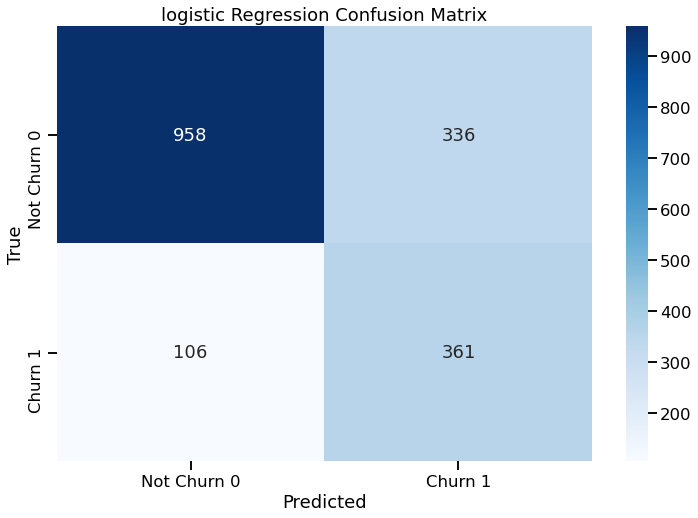

In [37]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="logistic Regression Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [38]:
#Storing evaluation metrics (average values)
lr_results = list()
for key in keys:
       lr_results.append(lr.get(key))
lr_results 

[0.7490062464508802, 0.798956073540853, 0.7490062464508802, 0.7615627377329636]

### Feature Importance

<b>Feature Weight</b>
using logisitc regression we can find the weight of each feature on the model, which basically represent each feature importance.

In [39]:
# storing evaluation metrics (per class)
lr_rpf = []
for element in elements:
       lr_rpf.append(lr.get(element))
lr_rpf   

[array([0.90037594, 0.517934  ]),
 array([0.74034003, 0.77301927]),
 array([0.81255301, 0.62027491])]

In [45]:
# this function will take the coeficients of the LR model and take the ones with highest value and lowest value so that we visualize them
from collections import OrderedDict
def highest_and_lowest_values(d):
    sorted_d = dict(OrderedDict(sorted(d.items(), key=lambda item: item[1], reverse=True)))
    highest_3 = dict(list(sorted_d.items())[:3])
    lowest_3 = dict(list(sorted_d.items())[-3:])
    return {**highest_3, **lowest_3}

In [53]:
coef_dict = get_feature_coefs(lr_model, 0, feature_cols)
top_dict = highest_and_lowest_values(coef_dict)
top_dict

{'InternetService_Fiber optic': 0.7573943010348606,
 'PaymentMethod_Electronic check': 0.35150066870753577,
 'StreamingMovies_Yes': 0.2892048371588706,
 'OnlineSecurity_Yes': -0.42079518445219394,
 'tenure': -1.1999201994826374,
 'Contract': -1.2578835902711363}

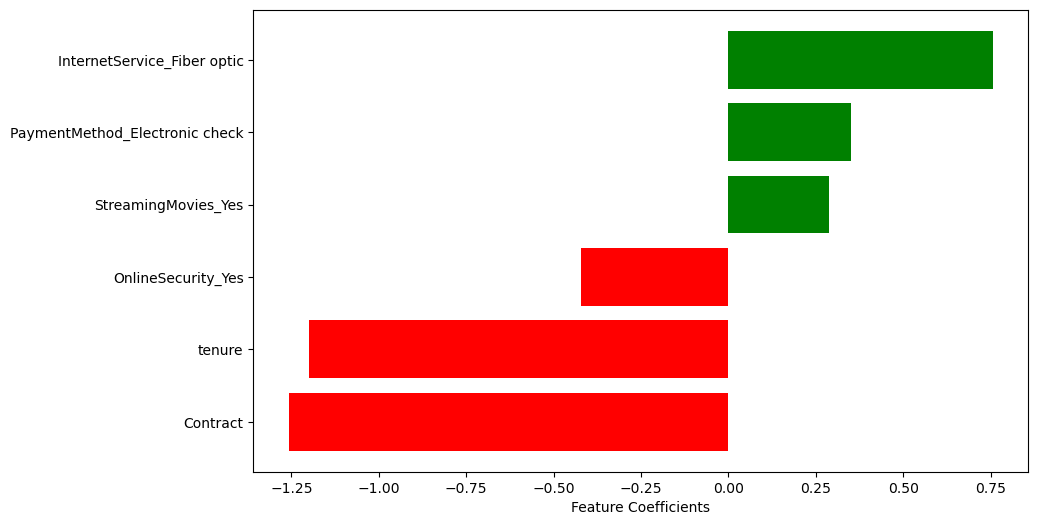

In [52]:
# Getting feature importance using logistic regression coefficients
# Get the coefficents for Class 1, Less Often

visualize_coefs(top_dict)

In [61]:
# Saving the ML model in case we need it int he future so we don't have to train it again.
pickle.dump(search_lr, open('search_lr.p','wb')) # wb: write - bytes
pickle.dump(lr_model, open('lr_model.p','wb')) # wb: write - bytes

### b. Support Vector Machine 

In [62]:
# # Identifying the param_grid to loop through it using GridSearchCV
# params_grid = {
#     'C': [0.1,1, 10, 100],
#     'kernel': ['poly', 'rbf', 'sigmoid']
# }

# model = SVC(class_weight=class_weight)

# # Define a GridSearchCV to search the best parameters
# SVC_search = GridSearchCV(estimator = model, 
#                            param_grid = params_grid, 
#                            scoring='f1',
#                            cv = skf, verbose = 1)
# # Search the best parameters with training data
# SVC_search.fit(X_train_s, y_train.values.ravel())
# best_params = SVC_search.best_params_
# best_params

In [62]:
SVM_model = SVC(C=1, kernel='rbf', class_weight=class_weight)
SVM_model.fit(X_train_s, y_train.values.ravel())
preds = SVM_model.predict(X_test_s)

In [63]:
svm_result = evaluate_metrics(y_test, preds)
svm_result

{'accuracy': 0.7331061896649631,
 'precision': array([0.9       , 0.49794802]),
 'Weighted precision': 0.7933797408666727,
 'recall': array([0.71638331, 0.77944325]),
 'Weighted recall': 0.7331061896649631,
 'f1score': array([0.79776248, 0.60767947]),
 'Weighted f1score': 0.7473543200894934}

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1294
           1       0.50      0.78      0.61       467

    accuracy                           0.73      1761
   macro avg       0.70      0.75      0.70      1761
weighted avg       0.79      0.73      0.75      1761



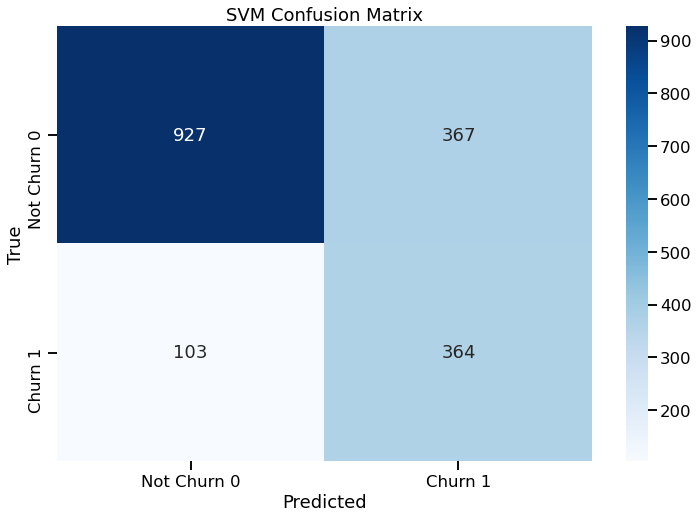

In [65]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="SVM Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [66]:
SVM_results = list()
for key in keys:
       SVM_results.append(svm_result.get(key))
SVM_results 

[0.7331061896649631,
 0.7933797408666727,
 0.7331061896649631,
 0.7473543200894934]

In [67]:
SVM_rpf = []
for element in elements:
       SVM_rpf.append(svm_result.get(element))
SVM_rpf  

[array([0.9       , 0.49794802]),
 array([0.71638331, 0.77944325]),
 array([0.79776248, 0.60767947])]

In [68]:
pickle.dump(SVM_model, open('SVM_model.p','wb')) # wb: write - bytes

### c. Random Forest

In [70]:
# using GridSearchCV to identify the best performing parameters
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
              'criterion':['gini', 'entropy'],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}
num_combinations = 1
for n in param_grid.values(): num_combinations *=len(n)
print("number of possible combinations for the parameters")
print(num_combinations)


number of possible combinations for the parameters
1200


In [109]:
RF_model = RandomForestClassifier(random_state = rs, bootstrap = True, class_weight = class_weight)
search_rf = GridSearchCV(estimator=RF_model,
                      param_grid=param_grid,
                      scoring='f1',
                      cv=skf,
                      n_jobs = -1) # creating GridSearchCV object
search_rf.fit(X_train_s, y_train)
search_rf.best_score_

0.6372738336695822

In [110]:
search_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 21}

building a random forest model using the best parameters

In [69]:
# choosing the best parameters to build the RF model.
RF_model = RandomForestClassifier(random_state = rs, bootstrap = True, class_weight = class_weight, 
                                 n_estimators =29, 
                                 criterion = 'gini',
                                 max_depth = 9 ,
                                 max_features = 'log2')

In [70]:
RF_model.fit(X_train_s,y_train)
preds = RF_model.predict(X_test_s)
RF_result = evaluate_metrics(y_test,preds)
RF_result

{'accuracy': 0.7637705848949461,
 'precision': array([0.88849558, 0.54041204]),
 'Weighted precision': 0.7961872226342678,
 'recall': array([0.77588872, 0.73019272]),
 'Weighted recall': 0.7637705848949461,
 'f1score': array([0.82838284, 0.62112933]),
 'Weighted f1score': 0.7734212311206078}

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1294
           1       0.54      0.73      0.62       467

    accuracy                           0.76      1761
   macro avg       0.71      0.75      0.72      1761
weighted avg       0.80      0.76      0.77      1761



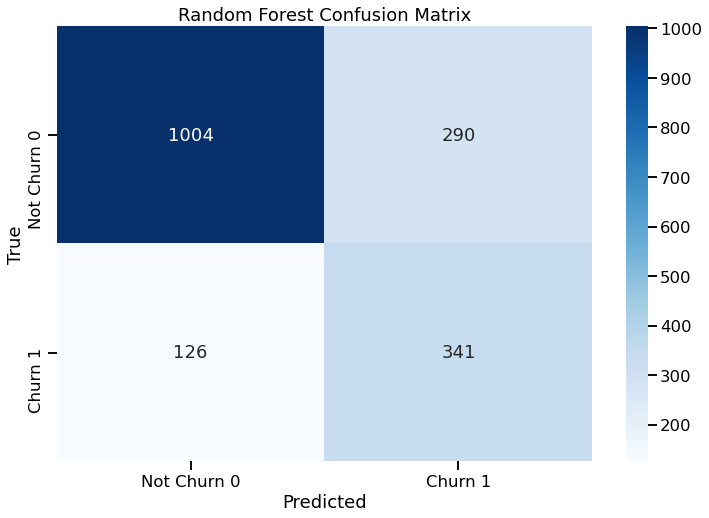

In [71]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="Random Forest Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [72]:
RF_results = list()
for key in keys:
       RF_results.append(RF_result.get(key))
RF_results 

[0.7637705848949461,
 0.7961872226342678,
 0.7637705848949461,
 0.7734212311206078]

In [73]:
RF_rpf = []
for element in elements:
       RF_rpf.append(RF_result.get(element))
RF_rpf  

[array([0.88849558, 0.54041204]),
 array([0.77588872, 0.73019272]),
 array([0.82838284, 0.62112933])]

In [261]:
pickle.dump(rf_model, open('RF_model.p','wb')) # write it as bytes

### d. XGboost

In [237]:
xgb.XGBClassifier().get_params() # printing XGboost parameters

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [123]:
# Splitting part of the training set to become the validation set for training XGboost
# Get the split indexes
strat_shuf_split_valid = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.15, # 25% to test the model peforamnce
                                          random_state=rs)

# We use 'next' to get the arrays from the generator object.
XGtrain_idx, XGvalid_idx = next(strat_shuf_split_valid.split(X_train_s, y_train))

# Create the train and validations sets
X_XGtrain = X_train_s.iloc[XGtrain_idx] # loc[index,column]
y_XGtrain = y_train.iloc[XGtrain_idx]

X_XGvalid  = X_train_s.iloc[XGvalid_idx]
y_XGvalid  = y_train.iloc[XGvalid_idx]

In [124]:
# weight parameter in XGBoost is per instance not per class.
# Therefore, we need to assign the weight of each class to its instances
from sklearn.utils import class_weight
classes_weights = list(class_weight.compute_class_weight(class_weight = 'balanced',
                                             classes = np.unique(y_XGtrain),
                                             y = y_XGtrain))

weights = np.ones(y_XGtrain.shape[0], dtype = 'float') # returns an array with predefined shape and values of 1
for i, val in enumerate(y_XGtrain):
    weights[i] = classes_weights[val]

weights


array([0.6807704, 1.8829698, 0.6807704, ..., 0.6807704, 0.6807704,
       1.8829698])

performing GridSearchSV to find the best parameters for XGboost

In [240]:
learning_rate_list = [0.02, 0.05, 0.1]
max_depth_list = [2, 3, 5]
n_estimators_list = [1000, 2000, 3000]

params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict

27


{'learning_rate': [0.02, 0.05, 0.1],
 'max_depth': [2, 3, 5],
 'n_estimators': [1000, 2000, 3000]}

In [241]:
def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_xgboost_hp = GridSearchCV(estimator=xgb.XGBClassifier(subsample=0.5,
                                                                colsample_bytree=0.25,
                                                                eval_metric='auc',
                                                                use_label_encoder=False),
                                param_grid=params_dict,
                                cv=2,
                                scoring=my_roc_auc_score,
                                return_train_score=True,
                                verbose=4)

model_xgboost_hp.fit(X_XGtrain,y_XGtrain)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=nan, test=nan) total time=   5.5s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=nan, test=nan) total time=   1.1s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=nan, test=nan) total time=   2.1s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=nan, test=nan) total time=   2.2s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=3000;, score=(train=nan, test=nan) total time=   3.8s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=3000;, score=(train=nan, test=nan) total time=   3.3s
[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=1000;, score=(train=nan, test=nan) total time=   1.3s
[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=1000;, score=(train=nan, test=nan) total time=   1.2s
[CV 1/2] END learning_rate=0.02, ma

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=0.5, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None),
             param_grid={'learning_rate': [0.02, 0.05, 0.1],
                         'max_depth': [2, 3, 5],
                         'n_estimators': [1000, 2000, 3000]},
             return_train_score=True,
             scoring=<function my_roc_auc_score at 0x000001D225C418B0>,
             verbose=4)

In [242]:
model_xgboost_hp.best_params_

{'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 1000}

In [125]:
# Initiating XGboost object
model_xgboost = xgb.XGBClassifier(learning_rate=0.02,
                                      max_depth=2,
                                      n_estimators=1000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=1)


eval_set = [(X_XGvalid, y_XGvalid)]

model_xgboost.fit(X_XGtrain,
                  y_XGtrain,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True,
                  sample_weight = weights)

[0]	validation_0-auc:0.78669
[1]	validation_0-auc:0.78797
[2]	validation_0-auc:0.79301
[3]	validation_0-auc:0.81494
[4]	validation_0-auc:0.82489
[5]	validation_0-auc:0.82644
[6]	validation_0-auc:0.82522
[7]	validation_0-auc:0.82222
[8]	validation_0-auc:0.82644
[9]	validation_0-auc:0.83000
[10]	validation_0-auc:0.83022
[11]	validation_0-auc:0.83254
[12]	validation_0-auc:0.83303
[13]	validation_0-auc:0.83184
[14]	validation_0-auc:0.83229
[15]	validation_0-auc:0.83160
[16]	validation_0-auc:0.83317
[17]	validation_0-auc:0.83323
[18]	validation_0-auc:0.83221
[19]	validation_0-auc:0.83275
[20]	validation_0-auc:0.83210
[21]	validation_0-auc:0.83301
[22]	validation_0-auc:0.83332
[23]	validation_0-auc:0.83363
[24]	validation_0-auc:0.83397
[25]	validation_0-auc:0.83446
[26]	validation_0-auc:0.83454
[27]	validation_0-auc:0.83375
[28]	validation_0-auc:0.83356
[29]	validation_0-auc:0.83439
[30]	validation_0-auc:0.83546
[31]	validation_0-auc:0.83525
[32]	validation_0-auc:0.83573
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=1)

In [126]:
preds = model_xgboost.predict(X_test_s)
XG_result = evaluate_metrics(y_test,preds)
XG_result

{'accuracy': 0.7387847813742192,
 'precision': array([0.9017341 , 0.50484094]),
 'Weighted precision': 0.796481913606637,
 'recall': array([0.72333849, 0.78158458]),
 'Weighted recall': 0.7387847813742192,
 'f1score': array([0.80274443, 0.61344538]),
 'Weighted f1score': 0.7525441669767395}

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1294
           1       0.50      0.78      0.61       467

    accuracy                           0.74      1761
   macro avg       0.70      0.75      0.71      1761
weighted avg       0.80      0.74      0.75      1761



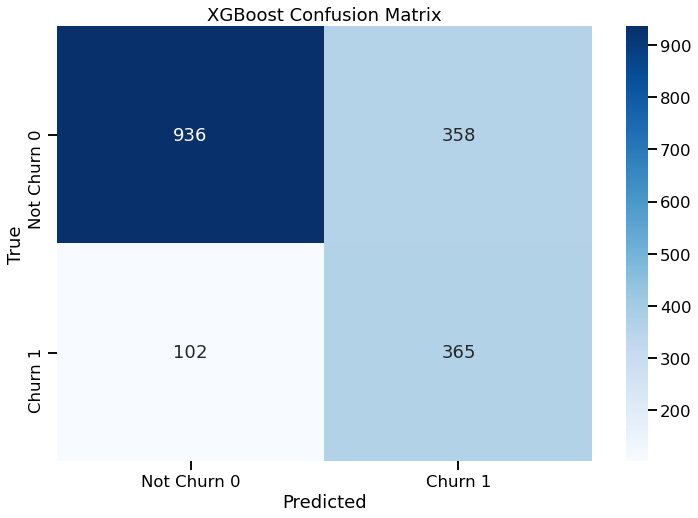

In [127]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="XGBoost Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [128]:
XG_results = list()
for key in keys:
       XG_results.append(XG_result.get(key))
XG_results 

[0.7387847813742192, 0.796481913606637, 0.7387847813742192, 0.7525441669767395]

In [129]:
XG_rpf = []
for element in elements:
       XG_rpf.append(XG_result.get(element))
XG_rpf 

[array([0.9017341 , 0.50484094]),
 array([0.72333849, 0.78158458]),
 array([0.80274443, 0.61344538])]

In [368]:
pickle.dump(model_xgboost, open('model_xgboost.p','wb')) # write it as bytes

### e. Light Gradient Boosted Machine LGBM

In [67]:
LGBMClassifier().get_params() # printing XGboost parameters

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [172]:
# defining the parameters to be tuned:
n_estimators= [100, 200, 300, 500, 1000]
num_leaves= [15, 20, 30]
colsample_bytree= [0.6, 0.8, 1]
subsample= [0.6, 0.8, 1]
max_depth= [1, 3, 5, 7, 9, 11]
reg_alpha= [0.6, 0.8, 1]
reg_lambda= [ 0.6, 0.8, 1]
min_split_gain=[0.02, 0.04]
learning_rate = [0.1, 0.2, 0.3]

param_grid = {
    'n_estimators':n_estimators,
    'num_leaves':num_leaves,
    'colsample_bytree':colsample_bytree,
    'subsample':subsample,
    'max_depth':max_depth,
    'reg_alpha':reg_alpha,
    'reg_lambda':reg_lambda,
    'min_split_gain':min_split_gain,
    'learning_rate':learning_rate
    
}

LGBM_model = LGBMClassifier( random_state = rs, bootstrap = True, class_weight = class_weight )


search_lgbm = GridSearchCV(estimator=LGBM_model,
                      param_grid=param_grid,
                      scoring='f1',
                      cv=skf,
                      n_jobs = -1) # creating GridSearchCV object

search_lgbm.fit(X_train_s, y_train)
search_lgbm.best_score_

0.6398977444027638

In [173]:
search_lgbm.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.2,
 'max_depth': 1,
 'min_split_gain': 0.02,
 'n_estimators': 300,
 'num_leaves': 15,
 'reg_alpha': 0.6,
 'reg_lambda': 0.8,
 'subsample': 0.6}

In [147]:

class_weight = {0: 0.26537, 
                1: 0.9}

clf_lgbm = LGBMClassifier(
  learning_rate = 0.2,
        n_estimators=300,
        num_leaves=15,
        colsample_bytree=0.6,
        subsample= 0.6,
        max_depth=7,
        reg_alpha=0.6,
        reg_lambda= 0.8,
        min_split_gain=.02,
        class_weight = class_weight,
        boosting_type= 'goss'
    )
# using the same train and validations set we used in XGboost.
clf_lgbm.fit(X_train_s,y_train,
        eval_set= [(X_test_s, y_test)], 
        eval_metric='recall', 
        verbose=0, 
        early_stopping_rounds=30
       )


LGBMClassifier(boosting_type='goss', class_weight={0: 0.26537, 1: 0.9},
               colsample_bytree=0.6, learning_rate=0.2, max_depth=7,
               min_split_gain=0.02, n_estimators=300, num_leaves=15,
               reg_alpha=0.6, reg_lambda=0.8, subsample=0.6)

In [148]:
preds = clf_lgbm.predict(X_test_s)
lgbm_result = evaluate_metrics(y_test,preds)
lgbm_result


{'accuracy': 0.7410562180579217,
 'precision': array([0.91403162, 0.50734312]),
 'Weighted precision': 0.8061818035101427,
 'recall': array([0.71483771, 0.8137045 ]),
 'Weighted recall': 0.7410562180579217,
 'f1score': array([0.80225499, 0.625     ]),
 'Weighted f1score': 0.7552486957215531}

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1294
           1       0.51      0.81      0.62       467

    accuracy                           0.74      1761
   macro avg       0.71      0.76      0.71      1761
weighted avg       0.81      0.74      0.76      1761



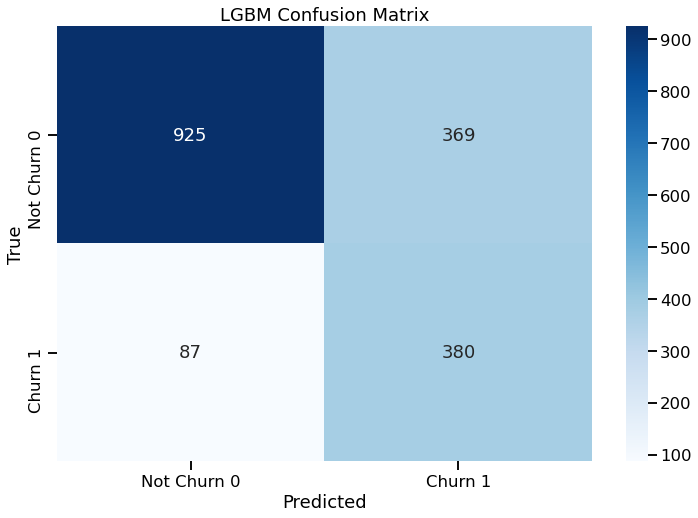

In [149]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="LGBM Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [150]:
LGBM_results = list()
for key in keys:
       LGBM_results.append(lgbm_result.get(key))
LGBM_results 

[0.7410562180579217,
 0.8061818035101427,
 0.7410562180579217,
 0.7552486957215531]

In [143]:
LGBM_rpf = []
for element in elements:
       LGBM_rpf.append(lgbm_result.get(element))
LGBM_rpf 

[array([0.91403162, 0.50734312]),
 array([0.71483771, 0.8137045 ]),
 array([0.80225499, 0.625     ])]

In [144]:
pickle.dump(clf_lgbm, open('clf_lgbm.p','wb')) # write it as bytes

In [145]:
final_results= {
    'Metric': ['Accuracy',' Weighted Precision','Weighted Recall','Weighted F1score'],
    'Logistic Regression' :lr_results,
    'SVM'                 :SVM_results,
    'Random Forest'      :RF_results,
    'XGboost'            :XG_results,
    'LGBM'               :LGBM_results}
final_results = pd.DataFrame(final_results).set_index('Metric')
display(final_results)    

,Logistic Regression,SVM,Random Forest,XGboost,LGBM
Metric,,,,,
Accuracy,0.749006,0.733106,0.763771,0.738785,0.741056
Weighted Precision,0.798956,0.793380,0.796187,0.796482,0.806182
Weighted Recall,0.749006,0.733106,0.763771,0.738785,0.741056
Weighted F1score,0.761563,0.747354,0.773421,0.752544,0.755249


In [146]:
final_results_per_class = {
    'classes': [0,1],
    'LR Precision' :lr_rpf[0],
    'LR Recall' :lr_rpf[1],
    'LR F1score' :lr_rpf[2],
    'SVM Precision':SVM_rpf[0],
    'SVM Recall':SVM_rpf[1],
    'SVM F1score':SVM_rpf[2],
    'RF Precision':RF_rpf[0],
    'RF Recall':RF_rpf[1],
    'RF F1 score':RF_rpf[2],
    'XG Precision':XG_rpf[0],
    'XG Recall':XG_rpf[1],
    'XG F1 score':XG_rpf[2],
    'LGBM Precision':LGBM_rpf[0],
    'LGBM Recall':LGBM_rpf[1],
    'LGBM F1 score':LGBM_rpf[2]}
final_results_per_class = pd.DataFrame(final_results_per_class).set_index('classes')
final_results_per_class.T

classes,0,1
LR Precision,0.900376,0.517934
LR Recall,0.740340,0.773019
LR F1score,0.812553,0.620275
SVM Precision,0.900000,0.497948
SVM Recall,0.716383,0.779443
SVM F1score,0.797762,0.607679
RF Precision,0.888496,0.540412
RF Recall,0.775889,0.730193
RF F1 score,0.828383,0.621129
XG Precision,0.901734,0.504841


### main outcomes:

* The data is sckewed by a percentage of approximately 70% to those who did not churn
* Random Forest Scored the highest accuracy, however, since reducing the number of churn is our main target, accuracy is not enough as a pefromance metrics
* XGboost scored the highest recall for churn class (1).however, it scored poorly on those who didn't churn which makes the prediction ineligible.
* LGBM scored decent recall average as it's weighted recall is not scewed by class 0

### Proposal for feature work:
* implementing LGBM model on a larger dataset (more than 10000 rows), since it's not suitable for small datasets and tuning it's parameters in small datasets has an unoticeable effect